# Align behavior and photometry, perform quality checks

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from photometry_analysis.io import process_photometry_data
from tqdm.auto import tqdm

In [3]:
base_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/mouse_open_field_lucid_rig_photometry_dlight_red_calcium/"
dframe_save_dir = os.path.join(base_dir, "_analysis")

In [4]:
save_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)/photometry_sessions/"
os.makedirs(save_dir, exist_ok=True)

In [5]:
proc_files = sorted(glob.glob(os.path.join(base_dir, "**", "labjack_data.txt"), recursive=True))

In [6]:
proc_dirs = [os.path.dirname(_proc) for _proc in proc_files]

In [7]:
len(proc_dirs)

123

## Extract data

In [8]:
mouse_dictionary = {
    "BL6J_017011_1-3_01": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-3_02": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-3_03": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-3_04": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-3_05": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-3_06": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017011_1-10_01": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "10:1"},
    "BL6J_017011_1-10_02": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "10:1"},
    "BL6J_017011_1-10_03": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "10:1"},
    "BL6J_017011_1-5_01": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "5:1"},
    "BL6J_017011_1-5_02": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "5:1"},
    "BL6J_017011_1-5_03": {"red_sensor": "scar-l01-069", "green_sensor": "jGCaMP8m", "ratio": "5:1"},
    "BL6J_017010_1-3_01": {"red_sensor": "jRCaMP1b", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017010_1-3_02": {"red_sensor": "jRCaMP1b", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017010_1-3_03": {"red_sensor": "jRCaMP1b", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017021_1-3_01": {"red_sensor": "jRCaMP1a", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017021_1-3_02": {"red_sensor": "jRCaMP1a", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
    "BL6J_017021_1-3_03": {"red_sensor": "jRCaMP1a", "green_sensor": "jGCaMP8m", "ratio": "3:1"},
}

In [9]:
# PREPROCESSING...
# def process_parallel(dir, save_file="photometry.parquet", force=True, **kwargs):
#     save_file_complete = os.path.join(dir, save_file)
#     if (not os.path.exists(save_file_complete)) or force:
#         results = process_photometry_data(dir, **kwargs)
#         results.to_parquet(save_file_complete)
#     else:
#         results = pd.read_parquet(save_file_complete)
#     return results

# config = {
#     "downsample_fs": 30,
#     "deconv_tau": 0.3,
#     "f0_tau": 10,
#     "dff_quantiles": [0.5, 0.5, 0.5],
#     "post_smoothing": None,
#     "force": False,
# }

# delays = [joblib.delayed(process_parallel)(_proc, **config) for _proc in proc_dirs]

# results = joblib.Parallel(n_jobs=-1, verbose=10)(delays)

# all_results = pd.concat(results, ignore_index=True)

# all_results["subject_alt"] = all_results["source_directory"].apply(lambda x: x.split(os.sep)[-2])
# all_results["session_alt"] = all_results["source_directory"].apply(lambda x: x.split(os.sep)[-1])

# for k, v in mouse_dictionary.items():
#     for k2, v2 in v.items():
#         all_results.loc[all_results["subject_alt"] == k, k2] = v2

# # chk_results = all_results.query("red_sensor == 'scar-l01-069'").dropna(subset=["ratio"])

# os.makedirs(dframe_save_dir, exist_ok=True)

# all_results.to_parquet(os.path.join(dframe_save_dir, "invivo_data.parquet"))

# Visualize all results

In [10]:
all_results = pd.read_parquet(os.path.join(dframe_save_dir, "invivo_data.parquet"))

In [11]:
chk_results = all_results.dropna(subset=["red_sensor", "ratio"])
all_sessions = chk_results["session_alt"].unique()

In [12]:
sns.set_context("paper")

In [13]:
force = False

In [14]:
for _session in tqdm(all_sessions):
    plt_results = chk_results.query("session_alt == @_session")
    plt_results = plt_results.loc[plt_results["timestamps"].between(10, 80)]
    plt_sensor = plt_results["red_sensor"].iat[0]
    plt_subject = plt_results["subject"].iat[0]
    save_fname = os.path.join(save_dir, f"{plt_sensor}-{plt_subject}-{_session}.pdf")

    if os.path.exists(save_fname) and not force:
        continue
    fig, ax = plt.subplots(1, figsize=(6, 3))
    plt_results.plot(x="timestamps", y="blueled_left_greenfluo_dff0", color="g", ax=ax, label="jGCaMP8f")
    h1 = plt_results.plot(x="timestamps", y="uvled_left_greenfluo_dff0", color="m", ax=ax, label="jGCaMP8f (iso)")
    ax2 = ax.twinx()
    h3 = plt_results.plot(x="timestamps", y="greenled_left_redfluo_dff0", color="r", ax=ax2, label=f"{plt_sensor}")
    ax2.spines["right"].set_color("r")
    ax2.tick_params(axis="y", colors="r")
    ax2.yaxis.label.set_color("r")

    ax_ylim = np.abs(np.array(ax.get_ylim())).max()
    ax2_ylim = np.abs(np.array(ax2.get_ylim())).max()

    ax.set_ylim(-ax_ylim, +ax_ylim)
    ax2.set_ylim(-ax2_ylim, +ax2_ylim)
    ax2.legend().remove()
    ax.legend().remove()
    # handles = [h1] + [h2] + [h3]
    lines = []
    for _line in h1.get_lines():
        lines.append(_line)
    lines.append(h3.get_lines()[0])
    labels = [_.get_label() for _ in lines]

    l = ax.legend(lines, labels)
    l.set(loc="center left", bbox_to_anchor=(1.15, 0.5))
    ax.set_title(f"{plt_sensor}-{plt_subject}-{_session}")
    # ax.set_xlim(5,80)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ΔF/F0 (jGCaMP8f and iso)")
    ax2.set_ylabel(f"ΔF/F0 ({plt_sensor})")
    fig.savefig(save_fname, dpi=600, bbox_inches="tight")
    plt.close(fig)
    # break

  0%|          | 0/78 [00:00<?, ?it/s]

### Visualize one session for the paper

In [15]:
# make a nicer plot of the session to use for the paper
# "scar-l01-069-BL6J_017011_1-5_01_d49"
paper_sessions = [
    "session_20241014103810-667507 (system76-pc)",
    "session_20241014125823-034299 (system76-pc)",
    "session_20241120122154-161951 (system76-pc)",
]

In [16]:
from calcium_imaging_analysis.fig import setup_plotting_env

In [17]:
setup_plotting_env()

In [18]:
red_sensors = chk_results["red_sensor"].unique()

In [19]:
# smoothing?
smoothing_kwargs = {
    "window": 3,
    "center": True,
}
smooth_kwargs = None
plt_fields = {
    "jGCaMP8m": "blueled_left_greenfluo_dff0",
    "jGCaMP8m (iso)": "uvled_left_greenfluo_dff0",
    # plt_sensor: "greenled_left_redfluo_dff0",
}
plt_colors = {
    "jGCaMP8m": "g",
    "jGCaMP8m (iso)": "m",
    # plt_sensor: "r",
}
for _sensor in red_sensors:
    plt_fields[_sensor] = "greenled_left_redfluo_dff0"
    plt_colors[_sensor] = "r"

BL6J_017011_1-5_01_d49_wheel


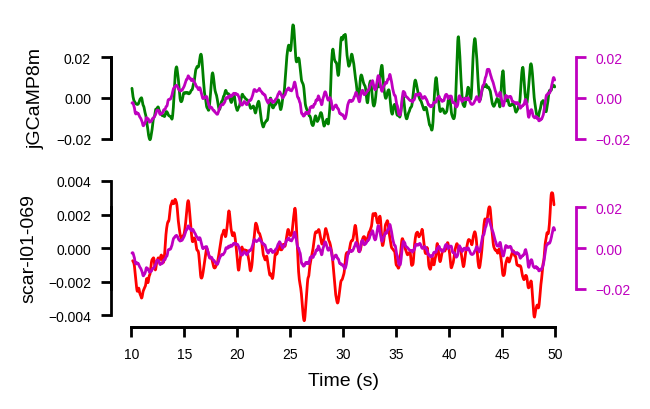

BL6J_017010_1-3_02_d13_wheel


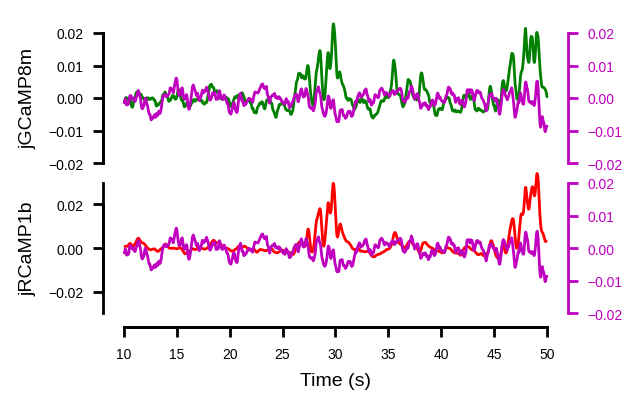

BL6J_017021_1-3_02_d16_wheel


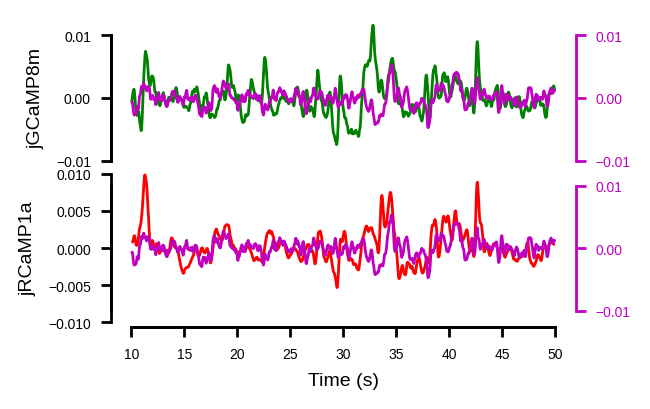

In [20]:
for _session in paper_sessions:
    plt_results = chk_results.query("session_alt == @_session").copy()
    plt_results = plt_results.loc[plt_results["timestamps"].between(10, 50)]
    plt_sensor = plt_results["red_sensor"].iat[0]
    plt_subject = plt_results["subject"].iat[0]
    print(plt_subject)
    save_fname = os.path.join(save_dir, f"forpaper-{plt_sensor}-{plt_subject}-{_session}")

    if smoothing_kwargs is not None:
        for _field in plt_fields.values():
            plt_results[_field] = plt_results[_field].rolling(**smoothing_kwargs).mean()

    fig, ax = plt.subplots(2, 1, figsize=(3, 2), sharex=True, sharey=False)
    show_fields = [
        ["jGCaMP8m", "jGCaMP8m (iso)"],
        [plt_sensor, "jGCaMP8m (iso)"],
    ]

    for i, (_show_fields, _ax) in enumerate(zip(show_fields, ax)):
        sns.lineplot(
            plt_results,
            x="timestamps",
            y=plt_fields[_show_fields[0]],
            color=plt_colors[_show_fields[0]],
            ax=_ax,
            label=_show_fields[0],
        )
        ax2 = _ax.twinx()
        sns.lineplot(
            plt_results,
            x="timestamps",
            y=plt_fields[_show_fields[1]],
            color=plt_colors[_show_fields[1]],
            ax=ax2,
            label=_show_fields[1],
        )

        ax2.spines["right"].set_color(plt_colors[_show_fields[1]])
        ax2.tick_params(axis="y", colors=plt_colors[_show_fields[1]])
        ax2.yaxis.label.set_color(plt_colors[_show_fields[1]])

        ax_ylim = np.abs(np.array(_ax.get_ylim())).max()
        ax2_ylim = np.abs(np.array(ax2.get_ylim())).max()
        if i == 0:
            alt_ylim = ax_ylim
        _ax.set_ylim(-ax_ylim, +ax_ylim)
        ax2.set_ylim(-alt_ylim, +alt_ylim)
        _ax.legend().remove()
        ax2.legend().remove()
        _ax.set_ylabel(_show_fields[0])
        ax2.set_ylabel("")
        sns.despine(ax=ax2, left=False, right=False, trim=True)
        sns.despine(ax=_ax, right=True, left=False, trim=True)

        if i == 0:
            ax2.spines["bottom"].set_visible(False)
            _ax.spines["bottom"].set_visible(False)
            _ax.tick_params(axis="x", length=0)

    ax[1].set_xlabel("Time (s)")
    fig.subplots_adjust(hspace=-0.05)
    fig.savefig(os.path.join(save_dir, f"{save_fname}-separate-axes.pdf"), dpi=600, bbox_inches="tight")
    plt.show()

# Stats: SNR and Autocorrelation

In [21]:
import scipy.signal as sig

In [22]:
def get_mad(x, scale=True, scaling_factor=0.6745):
    med = x.median()
    mad = (x - x.median()).abs().median()
    if scale:
        mad /= scaling_factor
    return mad

In [23]:
def get_quality_metrics(
    x,
    isos_key="uvled_left_greenfluo_dff0",
    red_key="greenled_left_redfluo_dff0",
    green_key="blueled_left_greenfluo_dff0",
    peak_quantile=0.99,
):

    red_peak = x[red_key].abs().quantile(peak_quantile)
    green_peak = x[green_key].abs().quantile(peak_quantile)
    isos_peak = x[isos_key].abs().quantile(peak_quantile)

    red_snr = red_peak / get_mad(x[red_key])
    green_snr = green_peak / get_mad(x[green_key])
    isos_snr = isos_peak / get_mad(x[isos_key])
    red_snr_isos = red_peak / isos_peak
    green_snr_isos = green_peak / isos_peak
    red_corr_isos = x[red_key].corr(x[isos_key])
    green_corr_isos = x[green_key].corr(x[isos_key])
    green_corr_red = x[red_key].corr(x[green_key])

    red_min = x[red_key].min()
    red_max = x[red_key].max()

    if np.abs(red_min) > np.abs(red_max):
        polarity = "neg"
    else:
        polarity = "pos"

    dct = {
        "red_snr": red_snr,
        "green_snr": green_snr,
        "red_snr_isos": red_snr_isos,
        "green_snr_isos": green_snr_isos,
        "red_corr_isos": np.abs(red_corr_isos),
        "green_corr_isos": np.abs(green_corr_isos),
        "red_peak": red_peak,
        "green_peak": green_peak,
        "greencorr_red": green_corr_red,
        "isos_snr": isos_snr,
        "polarity": polarity,
    }
    return dct

In [24]:
fs = np.round(1 / all_results.groupby("source_directory")["timestamps"].diff().median())

In [25]:
b, a = sig.ellip(4, 0.2, 40, [0.05, 3] / (fs / 2), "bandpass")

In [26]:
def get_autocorrelation(x, key="greenled_left_redfluo_dff0", max_lag=1000):
    use_signal = x[key].dropna().to_numpy()
    # use_signal[use_signal>0] = 0
    # use_signal = np.abs(use_signal)
    use_signal -= use_signal.mean()
    use_signal = sig.filtfilt(b, a, use_signal)
    # use_signal /= use_signal.std()

    autocorr = sig.correlate(use_signal, use_signal, "full")
    lags = sig.correlation_lags(len(use_signal), len(use_signal), "full")
    norm = np.var(use_signal) * len(use_signal)
    keep_idx = np.logical_and(lags >= 0, lags <= max_lag)
    return lags[keep_idx], autocorr[keep_idx] / norm

In [27]:
def get_eta(
    x,
    trigger_key="blueled_left_greenfluo_dff0",
    save_key="greenled_left_redfluo_dff0",
    max_lag=1000,
    direction="pos",
    pre_samp=60,
    post_samp=150,
):
    if trigger_key is None:
        trigger_key = save_key
    use_df = x[trigger_key].rolling(3, 1, True).mean()
    use_signal = use_df.to_numpy()
    save_signal = x[save_key].to_numpy()

    # remove nans
    nans = np.isnan(use_signal) | np.isnan(save_signal)
    use_signal = use_signal[~nans]
    save_signal = save_signal[~nans]

    threshold = get_mad(use_df) * 2
    if direction == "pos":
        event_indices = np.logical_and(use_signal[:-1] < threshold, use_signal[1:] >= threshold)
    else:
        event_indices = np.logical_and(use_signal[:-1] > -threshold, use_signal[1:] <= -threshold)
    event_indices = np.flatnonzero(event_indices)

    snippets = []
    for idx in event_indices:
        # for i in range(idx, idx - 20, -1):
        #     if (direction == "pos") and (use_signal[i] <= 0.001):
        #         idx = i
        #     elif (direction == "neg") and (use_signal[i] >= -0.001):
        #         idx = i

        if idx - pre_samp >= 0 and idx + post_samp < len(use_signal):
            snippet = save_signal[idx - pre_samp : idx + post_samp]
            snippets.append(snippet - np.mean(snippet[:5]))

    lags = np.arange(-pre_samp, post_samp)
    if len(snippets) > 1:
        avg = np.nanmean(snippets, axis=0)
        return lags, avg
    else:
        return lags, np.full_like(lags, fill_value=np.nan)

In [28]:
use_results = all_results.dropna(subset=["subject", "ratio"]).copy()

In [29]:
use_results = use_results.loc[use_results["subject"].str.contains("wheel").fillna(False)].copy()
# use_results = use_results.query("(red_sensor == 'scar-l01-069' and (ratio == '10:1' or ratio == '5:1')) or (red_sensor != 'scar-l01-069')")

In [30]:
session_stats = use_results.groupby("source_directory").apply(get_quality_metrics).apply(pd.Series)

/tmp/ipykernel_3479636/139095770.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_stats = use_results.groupby("source_directory").apply(get_quality_metrics).apply(pd.Series)


In [31]:
use_results = pd.merge(use_results, session_stats, on="source_directory")

In [32]:
use_results["red_sensor"] = use_results["red_sensor"].str.lower()
use_results["green_sensor"] = use_results["green_sensor"].str.lower()

In [33]:
criteria = "green_peak > .01 and red_peak > .0025 and red_snr > 3. and green_snr > 3 and red_corr_isos < .7"
criteria += " and ((red_sensor == 'scar-l01-069' and polarity == 'neg') "
criteria += "or (red_sensor != 'scar-l01--069' and polarity == 'pos'))"

In [34]:
corr_df = use_results.query(criteria)

In [35]:
autocorrs_red = corr_df.groupby(["red_sensor", "source_directory"]).apply(
    lambda x: get_autocorrelation(x, "greenled_left_redfluo_dff0")
)
autocorrs_green = corr_df.groupby(["green_sensor", "source_directory"]).apply(
    lambda x: get_autocorrelation(x, "blueled_left_greenfluo_dff0")
)

/tmp/ipykernel_3479636/560131829.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  autocorrs_red = corr_df.groupby(["red_sensor", "source_directory"]).apply(
/tmp/ipykernel_3479636/560131829.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  autocorrs_green = corr_df.groupby(["green_sensor", "source_directory"]).apply(


In [36]:
align_to = "self"
if align_to == "green":
    trigger_key = "blueled_left_greenfluo_dff0"
else:
    trigger_key = None

In [37]:
etas_red_pos = corr_df.groupby(["red_sensor", "source_directory"]).apply(
    lambda x: get_eta(x, trigger_key=trigger_key, save_key="greenled_left_redfluo_dff0")
)
etas_red_neg = corr_df.groupby(["red_sensor", "source_directory"]).apply(
    lambda x: get_eta(x, trigger_key=trigger_key, save_key="greenled_left_redfluo_dff0", direction="negative")
)
etas_green_pos = corr_df.groupby(["green_sensor", "source_directory"]).apply(
    lambda x: get_eta(x, trigger_key=trigger_key, save_key="blueled_left_greenfluo_dff0")
)

/tmp/ipykernel_3479636/2650695960.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  etas_red_pos = corr_df.groupby(["red_sensor", "source_directory"]).apply(
/tmp/ipykernel_3479636/2650695960.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  etas_red_neg = corr_df.groupby(["red_sensor", "source_directory"]).apply(
/tmp/ipykernel_3479636/2650695960.py:7: DeprecationWarning: DataFrameGroupBy.apply operate

In [38]:
red_sensors = list(etas_red_pos.index.get_level_values(0).unique())
green_sensors = list(etas_green_pos.index.get_level_values(0).unique())

In [39]:
dfs = []

if align_to == "green":
    traces = np.hstack([_eta for _lags, _eta in etas_red_pos.loc["scar-l01-069"]])[:, None]
    lags = np.hstack([_lags for _lags, _eta in etas_red_pos.loc["scar-l01-069"]])[:, None]
    trials = np.hstack([[i] * len(_lags) for i, (_lags, _eta) in enumerate(etas_red_pos.loc["scar-l01-069"])])[:, None]
else:
    traces = np.hstack([_eta for _lags, _eta in etas_red_neg.loc["scar-l01-069"]])[:, None]
    lags = np.hstack([_lags for _lags, _eta in etas_red_neg.loc["scar-l01-069"]])[:, None]
    trials = np.hstack([[i] * len(_lags) for i, (_lags, _eta) in enumerate(etas_red_neg.loc["scar-l01-069"])])[:, None]
_df = pd.DataFrame(np.hstack([traces, lags, trials]), columns=["dff0", "lag", "trial"])
_df["sensor"] = "scar-l01-069"
_df["polarity"] = "neg"
dfs.append(_df)

traces = np.hstack([_eta for _lags, _eta in etas_red_pos.loc["jrcamp1b"]])[:, None]
lags = np.hstack([_lags for _lags, _eta in etas_red_pos.loc["jrcamp1b"]])[:, None]
trials = np.hstack([[i] * len(_lags) for i, (_lags, _eta) in enumerate(etas_red_pos.loc["jrcamp1b"])])[:, None]
_df = pd.DataFrame(np.hstack([traces, lags, trials]), columns=["dff0", "lag", "trial"])
_df["sensor"] = "jrcamp1b"
_df["polarity"] = "pos"
dfs.append(_df)

traces = np.hstack([_eta for _lags, _eta in etas_red_pos.loc["jrcamp1a"]])[:, None]
lags = np.hstack([_lags for _lags, _eta in etas_red_pos.loc["jrcamp1a"]])[:, None]
trials = np.hstack([[i] * len(_lags) for i, (_lags, _eta) in enumerate(etas_red_pos.loc["jrcamp1a"])])[:, None]
_df = pd.DataFrame(np.hstack([traces, lags, trials]), columns=["dff0", "lag", "trial"])
_df["sensor"] = "jrcamp1a"
_df["polarity"] = "pos"
dfs.append(_df)

traces = np.hstack([_eta for _lags, _eta in etas_green_pos.loc["jgcamp8m"]])[:, None]
lags = np.hstack([_lags for _lags, _eta in etas_green_pos.loc["jgcamp8m"]])[:, None]
trials = np.hstack([[i] * len(_lags) for i, (_lags, _eta) in enumerate(etas_green_pos.loc["jgcamp8m"])])[:, None]
_df = pd.DataFrame(np.hstack([traces, lags, trials]), columns=["dff0", "lag", "trial"])
_df["sensor"] = "jgcamp8m"
_df["polarity"] = "pos"
dfs.append(_df)

In [40]:
trace_df = pd.concat(dfs, ignore_index=True)

In [41]:
trace_df["lag"] = trace_df["lag"].astype("int")
trace_df["trial"] = trace_df["trial"].astype("int")
trace_df["time"] = trace_df["lag"] / fs

In [42]:
def minmax_norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [43]:
# trace_df.loc[trace_df["polarity"] == "neg", "dff0"] *= -1

In [44]:
trace_df["dff0_norm"] = trace_df.groupby(["sensor", "trial"])["dff0"].transform(minmax_norm)

In [45]:
sns.color_palette("tab20")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [46]:
sns.color_palette("tab20")[6]

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)

In [47]:
palette = {
    "jgcamp8m": sns.color_palette("tab20")[4],
    "jrcamp1a": sns.color_palette("tab20")[1],
    "jrcamp1b": sns.color_palette("tab20")[0],
    "scar-l01-069": sns.color_palette("tab20")[6],
}

In [48]:
hue_order = ["scar-l01-069", "jrcamp1a", "jrcamp1b", "jgcamp8m"]

In [49]:
trace_df["sensor"].value_counts()

sensor
jgcamp8m        6930
scar-l01-069    3360
jrcamp1b        2520
jrcamp1a        1050
Name: count, dtype: int64

In [50]:
from calcium_imaging_analysis.fig import setup_plotting_env, pal

In [51]:
trace_df["sensor"] = trace_df["sensor"].replace("scar-l01-069", "scarcamp")
corr_df["red_sensor"] = corr_df["red_sensor"].replace("scar-l01-069", "scarcamp")
hue_order = ["jrcamp1b", "jrcamp1a", "scarcamp"]

/tmp/ipykernel_3479636/615367127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df["red_sensor"] = corr_df["red_sensor"].replace("scar-l01-069", "scarcamp")


In [52]:
pal["jgcamp8m"] = sns.color_palette("tab10")[2]

In [53]:
nsessions = trace_df.groupby("sensor")["trial"].nunique()
nmice = corr_df.groupby("red_sensor")["subject_alt"].nunique()

In [54]:
corr_df.groupby("red_sensor")["subject_alt"].unique().loc["scarcamp"]

array(['BL6J_017011_1-10_01', 'BL6J_017011_1-10_02',
       'BL6J_017011_1-10_03', 'BL6J_017011_1-5_02'], dtype=object)

In [55]:
show_text = ""
for k, v in nsessions.items():
    if k in hue_order:
        show_text += f"{k}: n(ses.){v} n(mice):{nmice[k]}\n"

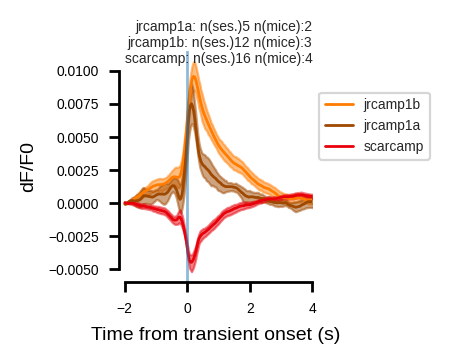

In [56]:
fig, ax = plt.subplots(1, figsize=(1.25, 1.5))
sns.lineplot(
    data=trace_df,
    x="time",
    y="dff0",
    err_kws={"alpha": 0.5},
    hue="sensor",
    hue_order=hue_order,
    palette=pal,
    errorbar=("ci", 95),
)
ax.legend(bbox_to_anchor=(1, 0.5))
ax.axvline(x=0, alpha=0.5)
# ax.set_xlabel("Time from jGCaMP8m transient onset (s)")
ax.set_ylabel("dF/F0")
ax.set_xlim(-2.2, 4)
sns.despine(trim=True)
ylims = ax.get_ylim()
xlims = ax.get_xlim()
ax.text(xlims[1], ylims[1], show_text, ha="right", va="center", fontsize=5)
ax.set_xlabel("Time from transient onset (s)")
fig.savefig(os.path.join(save_dir, "../in_vivo_transient_response.pdf"), bbox_inches="tight", dpi=600)

In [57]:
peaks = trace_df.query("lag.between(-5,30)").groupby(["sensor", "trial"])["dff0"].apply(lambda x: x.abs().max())

/tmp/ipykernel_3479636/4181230381.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


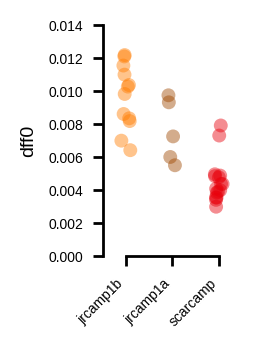

In [58]:
fig, ax = plt.subplots(1, figsize=(0.9, 1.5))
sns.stripplot(
    data=peaks.reset_index(),
    hue="sensor",
    hue_order=hue_order,
    palette=pal,
    x="sensor",
    order=hue_order,
    y="dff0",
    alpha=0.45,
    ax=ax,
)
# sns.boxplot(
#     data=peaks.reset_index(),
#     hue="sensor",
#     hue_order=hue_order,
#     palette=pal,
#     x="sensor",
#     order=hue_order,
#     y="dff0",
#     # alpha=0.45,
#     showfliers=False,
#     showcaps=False,
#     ax=ax,
# )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("")
ax.set_ylim(0, 0.014)
sns.despine(trim=True)
fig.savefig(os.path.join(save_dir, "../in_vivo_transient_response_summary.pdf"), bbox_inches="tight", dpi=600)

In [59]:
def get_timing_metrics(df, x="time", y="dff0"):
    # get peak, walk backwards to takeoff?
    # or get takeoff, calculate time to peak

    df_dt = df[y].rolling(5, 1, True).mean().diff()
    df_dt_z = (df_dt - df_dt.mean()) / df_dt.std()

    max_loc = np.argmax(df[y])
    min_loc = np.argmin(df[y])
    is_pos = abs(df.iloc[max_loc][y]) > abs(df.iloc[min_loc][y])

    if is_pos:
        peak_loc = max_loc
    else:
        df_dt[y] = -df_dt
        df_dt_z = -df_dt_z
        peak_loc = min_loc

    # print(df.loc[peak_loc,x])
    for i in range(peak_loc, 0, -1):
        # go until turning point
        if df_dt_z.iloc[i] < 0.25:
            break
    try:
        takeoff = i
    except:
        return None

    for i in range(peak_loc + 1, len(df)):
        if df_dt_z.iloc[i] > -0.1:
            break
    try:
        baseline = i
    except:
        return None

    print(baseline)

    return {
        "time_to_peak": df.iloc[peak_loc][x] - df.iloc[takeoff][x],
        "time_to_baseline": df.iloc[baseline][x] - df.iloc[peak_loc][x],
    }

In [60]:
time_to_peak = trace_df.query("lag.between(-60,150)").groupby(["sensor","trial"]).apply(get_timing_metrics)

100
95
95
102
65
104
104
94
100
99
66
102
66
102
98
100
99
100
96
91
89
101
102
65
120
110
86
101
93
100
91
84
95
92
74
82
64
97
110
96
141
128
104
67
104
106
99
172
68
110
64
64
64
97
63
76
116
129
101
64
104
76
95
64
118
140


/tmp/ipykernel_3479636/100063077.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_to_peak = trace_df.query("lag.between(-60,150)").groupby(["sensor","trial"]).apply(get_timing_metrics)


In [61]:
red_stats = [_stat for _stat in session_stats.columns if ("red" in _stat) and ("greencorr" not in _stat)]
green_stats = [_stat for _stat in session_stats.columns if "green" in _stat and ("greencorr" not in _stat)]

In [62]:
red_stats_df = use_results.groupby(["red_sensor", "ratio", "source_directory"])[red_stats].mean()
green_stats_df = use_results.groupby(["green_sensor", "ratio", "source_directory"])[green_stats].mean()

green_stats_df.columns = [_col.replace("green_", "") for _col in green_stats_df.columns]
red_stats_df.columns = [_col.replace("red_", "") for _col in red_stats_df.columns]
green_stats_df.index.names = ["sensor", "ratio", "source_directory"]
red_stats_df.index.names = ["sensor", "ratio", "source_directory"]

In [63]:
plt_stats_df = pd.concat([green_stats_df, red_stats_df]).melt(ignore_index=False).reset_index()

In [64]:
plt_stats_df["sensor"] = plt_stats_df["sensor"].str.lower()

In [65]:
plt_df = plt_stats_df.query("(sensor != 'jgcamp8m') or (sensor == 'jgcamp8m' and ratio == '3:1')")